In [75]:
import os
import time
import numpy as np
import pandas as pd
from datetime import datetime, date
from dateutil.relativedelta import relativedelta
import community
import networkx as nx
import cpnet
import warnings 
from web3 import Web3
warnings.filterwarnings('ignore')

In [76]:
SAVE_PATH = '../Data/'
token_name = 'AAVE'
today = '22-07-12'

SAVE_DIR = f"{SAVE_PATH}{token_name}_{today}"
if os.path.exists(SAVE_DIR) is False:
    os.makedirs(SAVE_DIR)

In [77]:
# Read data
today = '22-07-12' #date.today().strftime('%y-%m-%d')
dtypes = {'token_address':str, 'from_address':str, 'to_address':str, 'timestamp':str, 'value':np.float64}
data = pd.read_csv(f"../Data/{token_name}_{today}.csv", dtype=dtypes)
data = data[data['from_address'] != '0x0000000000000000000000000000000000000000']
data = data[data['to_address'] != '0x0000000000000000000000000000000000000000']

start_date = list(data['timestamp'].unique())[-1]
end_date = list(data['timestamp'].unique())[0]

# Aggregate tx values between the addresses pair on the same day
agg_data = data.groupby(['timestamp','from_address','to_address']).sum().reset_index()

In [78]:
network_fea = pd.read_csv(f"../Data/{token_name}_{today}/02_network_fea.csv")
core_days_cnt = pd.read_csv(f"../Data/{token_name}_{today}/03_core_address.csv")

In [79]:
def cal_address(agg_df):
    return len(set(list(agg_df['from_address'].unique()) + list(agg_df['to_address'].unique())))

print(f'Duration: {len(network_fea)}')
print(f'Total Transaction Value: {sum(agg_data.value)}')
print(f'Number of Addresses: {cal_address(agg_data)}')

Duration: 649
Total Transaction Value: 3.510682967343212e+26
Number of Addresses: 371122


In [216]:
def get_network_features(x):
    # Construct daily tx graph
    G = nx.from_pandas_edgelist(
        x, 'from_address', 'to_address', 'value', nx.Graph())
    result_dic = dict()

    # Number of nodes and edges
    num_edges = len(x['index'].unique())
    num_nodes = len(set(list(x['from_address'])+list(x['to_address'])))

    result_dic['num_edges'] = [num_edges]
    result_dic['num_nodes'] = [num_nodes]

    # Degree mean & std
    degree = list(dict(G.degree()).values())
    degree_mean = np.mean(degree)
    degree_std = np.std(degree)

    result_dic['degree_mean'] = [degree_mean]
    result_dic['degree_std'] = [degree_std]

    # Top 10 degree mean & std
    degree.sort(reverse=True)
    top_degree = degree[:10]
    top10_degree_mean = np.mean(top_degree)
    top10_degree_std = np.std(top_degree)

    result_dic['top10_degree_mean'] = [top10_degree_mean]
    result_dic['top10_degree_std'] = [top10_degree_std]

    # Degree centrality mean & std
    degree_centrality = list(nx.degree_centrality(G).values())
    degree_centrality_mean = np.mean(degree_centrality)
    degree_centrality_std = np.std(degree_centrality)

    result_dic['degree_centrality_mean'] = [degree_centrality_mean]
    result_dic['degree_centrality_std'] = [degree_centrality_std]

    # Modularity
    modularity = community.modularity(community.best_partition(G), G)
    result_dic['modularity'] = [modularity]

    # Transitivity
    transitivity = nx.transitivity(G)
    result_dic['transitivity'] = [transitivity]

    # Eigenvector centrality mean & std
    eig_cen = list(nx.eigenvector_centrality(G, max_iter=20000).values())
    eigenvector_centrality_mean = np.mean(eig_cen)
    eigenvector_centrality_atd = np.std(eig_cen)

    result_dic['eigenvector_centrality_mean'] = [eigenvector_centrality_mean]
    result_dic['eigenvector_centrality_atd'] = [eigenvector_centrality_atd]

    # Closeness centrality mean & std
    close_cen = list(nx.closeness_centrality(G).values())
    closeness_centrality_mean = np.mean(close_cen)
    closeness_centrality_std = np.std(close_cen)

    result_dic['closeness_centrality_mean'] = [closeness_centrality_mean]
    result_dic['closeness_centrality_std'] = [closeness_centrality_std]

    # Number of components
    num_components = nx.number_connected_components(G)
    result_dic['num_components'] = [num_components]

    # Size of gaint component / num of nodes
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    gaintG = G.subgraph(Gcc[0])
    giant_com_ratio = (1.0*gaintG.number_of_nodes())/G.number_of_nodes()
    result_dic['giant_com_ratio'] = [giant_com_ratio]

    return pd.DataFrame(result_dic)

In [217]:
print('============ Network Features ============')
print(f'{token_name}')
time_start = time.time()
# Get network features
network_fea = agg_data.reset_index().groupby('timestamp').apply(get_network_features).reset_index()
network_fea.drop(columns=['level_1'], inplace=True)

# Calculate top10_degree_ratio
network_fea['top10_degree_ratio'] = network_fea['top10_degree_mean'] / network_fea['degree_mean']

# Rearrange columns
cols = list(network_fea.columns)
network_fea = network_fea[cols[:7] + [cols[-1]] + cols[7:-1]]

# Print info
print(f'>> Number of features: {network_fea.shape[1]}')
print(f'>> Time to calculate network feature: {time.time()-time_start:.2f}s') 
print('=========================================================\n')

============ Network Features ============
AAVE
>> Number of features: 18
>> Time to calculate network feature: 1867.79s



In [63]:
# addresses = list(set(list(agg_data['from_address'].unique()) + list(agg_data['to_address'].unique())))
# # addresses_id_dict = {addresses[i]:i for i in range(len(addresses))}

# agg_data['from_address'] = agg_data['from_address'].apply(lambda x: addresses_id_dict[x])
# agg_data['to_address'] = agg_data['to_address'].apply(lambda x: addresses_id_dict[x])
# agg_data.head()

In [31]:
def get_core_neighbor(tx_df):
    # Construct daily tx graph
    G = nx.from_pandas_edgelist(
        tx_df, 'from_address', 'to_address', 'value', nx.Graph())

    # Detecting discrete core-periphery structure
    # alg = cpnet.MINRES()
    alg = cpnet.Lip()
    alg.detect(G)
    x = alg.get_coreness()

    # Calculate avg_core_neighbor
    # core_addresses = [a for a in x if x[a] > 0.62]
    core_addresses = [a for a in x if x[a] == 1]
    # get their degrees
    degree = list(dict(G.degree(core_addresses)).values())
    # average number of degree, i.e., avg_core_neighbor
    avg_core_neighbor = np.mean(degree)

    return pd.DataFrame({'num_core': [len(core_addresses)],
                         'avg_core_neighbor': [avg_core_neighbor],
                         'core_addresses': [core_addresses]})

In [32]:
print(agg_data['timestamp'].unique()[0])
print(agg_data['timestamp'].unique()[-1])

2020-10-02
2022-07-12


In [33]:
date_t = agg_data['timestamp'].unique()[0]
agg_data_t = agg_data[(agg_data['timestamp'] >= date_t) & (agg_data['timestamp'] < '2022-12-31')]

print(f'Number of TX: {len(agg_data_t)} | Number of addresses: {cal_address(agg_data_t)}')

time_start = time.time()
network_fea_t = agg_data_t.reset_index().groupby('timestamp').apply(get_core_neighbor).reset_index()
print(f'>> Time {time.time()-time_start:.2f}s | Date {date_t}') 

Number of TX: 1031189 | Number of addresses: 371122
>> Time 13.19s | Date 2020-10-02


In [34]:
core_addresses_list = [core_address for core_addresses in list(network_fea_t.core_addresses) for core_address in core_addresses]
core_days_cnt = pd.Series(core_addresses_list).value_counts(ascending=False).reset_index()
core_days_cnt.columns = ['address', 'core_days_cnt']

# id_addresses_dict = {addresses_id_dict[k]: k for k in addresses_id_dict}

# core_days_cnt['address'] = core_days_cnt['address'].apply(lambda x: id_addresses_dict[x])

core_days_cnt

,address,core_days_cnt
0,0x4da27a545c0c5b758a6ba100e3a049001de870f5,642
1,0xd75ea151a61d06868e31f8988d28dfe5e9df57b4,635
2,0xdfc14d2af169b0d36c4eff567ada9b2e0cae044f,607
3,0x25f2226b597e8f9514b3f68f00f494cf4f286491,555
4,0x26a78d5b6d7a7aceedd1e6ee3229b372a624d8b7,516
...,...,...
345,0x519bf4613ce9db811a0cd8e55fe0857125cac848,1
346,0x3b04e6632be922392367b0e199ad19462e117e83,1
347,0x8e53ea8f27793728e860e84bdbb9a8826df5bcaf,1
348,0xbe644da9d84b8292410026213c1094fc22ea4bfe,1


In [35]:
def get_CA_EOA(core_address):
    infura_url = 'https://mainnet.infura.io/v3/fc6dbeee65044e24a744ff54fec1718d' #args.infura_url
    web3 = Web3(Web3.HTTPProvider(infura_url))

    core_address['type'] = core_address['address'].apply(lambda x: 1 if web3.eth.get_code(Web3.toChecksumAddress(x)).hex()=='0x' else 0)
    core_CA = core_address[core_address['type'] == 0]
    core_EOA = core_address[core_address['type'] == 1]

    CA_str = 'CA ({:.4}%)'.format(100*len(core_CA)/len(core_address))
    EOA_str = 'EOA ({:.4}%)'.format(100*core_EOA.shape[0]/core_address.shape[0])

    print('CA VS EOA: {} {} | {} {}'.format(len(core_CA), CA_str, core_EOA.shape[0], EOA_str))

    return {
        'core_address':core_address[core_address['address'] != '0x0000000000000000000000000000000000000000'], 
        'CA_str': CA_str, 
        'EOA_str': EOA_str
        }

core_address_dict = get_CA_EOA(core_days_cnt)
core_address = core_address_dict['core_address']
CA_str = core_address_dict['CA_str']
EOA_str = core_address_dict['EOA_str']
core_days_cnt

CA VS EOA: 74 CA (21.14%) | 276 EOA (78.86%)


,address,core_days_cnt,type
0,0x4da27a545c0c5b758a6ba100e3a049001de870f5,642,0
1,0xd75ea151a61d06868e31f8988d28dfe5e9df57b4,635,0
2,0xdfc14d2af169b0d36c4eff567ada9b2e0cae044f,607,0
3,0x25f2226b597e8f9514b3f68f00f494cf4f286491,555,0
4,0x26a78d5b6d7a7aceedd1e6ee3229b372a624d8b7,516,1
...,...,...,...
345,0x519bf4613ce9db811a0cd8e55fe0857125cac848,1,1
346,0x3b04e6632be922392367b0e199ad19462e117e83,1,1
347,0x8e53ea8f27793728e860e84bdbb9a8826df5bcaf,1,1
348,0xbe644da9d84b8292410026213c1094fc22ea4bfe,1,1


In [36]:
network_fea_t

,timestamp,level_1,num_core,avg_core_neighbor,core_addresses
0,2020-10-02,0,5,308.200000,"[0x4da27a545c0c5b758a6ba100e3a049001de870f5, 0..."
1,2020-10-03,0,10,300.600000,"[0x7c90a3cd7ec80dd2f633ed562480abbeed3be546, 0..."
2,2020-10-04,0,8,139.375000,"[0x7c90a3cd7ec80dd2f633ed562480abbeed3be546, 0..."
3,2020-10-05,0,7,124.428571,"[0xdfc14d2af169b0d36c4eff567ada9b2e0cae044f, 0..."
4,2020-10-06,0,9,75.222222,"[0x7c90a3cd7ec80dd2f633ed562480abbeed3be546, 0..."
...,...,...,...,...,...
644,2022-07-08,0,17,33.000000,"[0x5ab53ee1d50eef2c1dd3d5402789cd27bb52c1bb, 0..."
645,2022-07-09,0,18,39.722222,"[0x59c38b6775ded821f010dbd30ecabdcf84e04756, 0..."
646,2022-07-10,0,17,34.352941,"[0x1353fe67fff8f376762b7034dc9066f0be15a723, 0..."
647,2022-07-11,0,17,29.294118,"[0x00000000ae347930bd1e7b0f35588b92280f9e75, 0..."


In [37]:
network_fea

,timestamp,num_edges,num_nodes,degree_mean,degree_std,top10_degree_mean,top10_degree_std,top10_degree_ratio,degree_centrality_mean,degree_centrality_std,modularity,transitivity,eigenvector_centrality_mean,eigenvector_centrality_atd,closeness_centrality_mean,closeness_centrality_std,num_components,giant_com_ratio,num_core,avg_core_neighbor
0,2020-10-02,1567,863,3.622248,33.753260,156.1,273.464239,43.094786,0.004202,0.039157,0.200804,0.000067,0.024383,0.023753,0.484581,0.037384,1,1.000000,5,308.200000
1,2020-10-03,3167,1819,3.416163,45.854432,300.6,541.847063,87.993466,0.001879,0.025222,0.212698,0.000025,0.015734,0.017384,0.424829,0.064252,4,0.996701,10,300.600000
2,2020-10-04,1173,695,3.312230,26.767618,112.6,194.047520,33.995222,0.004773,0.038570,0.246427,0.000036,0.025617,0.027975,0.405767,0.072374,4,0.991367,8,139.375000
3,2020-10-05,929,576,3.156250,23.035071,88.6,152.032365,28.071287,0.005489,0.040061,0.276692,0.000116,0.027902,0.030945,0.395485,0.072016,3,0.993056,7,124.428571
4,2020-10-06,753,460,3.147826,18.172360,68.4,103.996346,21.729282,0.006858,0.039591,0.376158,0.000387,0.029885,0.035788,0.354695,0.069910,3,0.991304,9,75.222222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,2022-07-08,1037,758,2.585752,5.879162,42.5,23.846383,16.436224,0.003416,0.007766,0.720898,0.012488,0.015410,0.032891,0.147906,0.073474,55,0.819261,17,33.000000
645,2022-07-09,1199,891,2.576880,6.606248,55.8,22.274649,21.654094,0.002895,0.007423,0.745911,0.008046,0.016620,0.029088,0.149423,0.063584,48,0.865320,18,39.722222
646,2022-07-10,1090,791,2.616941,5.738610,43.4,20.145471,16.584251,0.003313,0.007264,0.731608,0.015716,0.014002,0.032683,0.144293,0.066791,54,0.836915,17,34.352941
647,2022-07-11,881,668,2.497006,5.408603,37.1,19.449679,14.857794,0.003744,0.008109,0.741406,0.008442,0.015201,0.035580,0.149617,0.068471,45,0.841317,17,29.294118


In [38]:
# network_fea = network_fea[network_fea['timestamp'] >= '2019-11-18']
network_fea['num_core'] = network_fea_t['num_core']
network_fea['avg_core_neighbor'] = network_fea_t['avg_core_neighbor']
network_fea

,timestamp,num_edges,num_nodes,degree_mean,degree_std,top10_degree_mean,top10_degree_std,top10_degree_ratio,degree_centrality_mean,degree_centrality_std,modularity,transitivity,eigenvector_centrality_mean,eigenvector_centrality_atd,closeness_centrality_mean,closeness_centrality_std,num_components,giant_com_ratio,num_core,avg_core_neighbor
0,2020-10-02,1567,863,3.622248,33.753260,156.1,273.464239,43.094786,0.004202,0.039157,0.200804,0.000067,0.024383,0.023753,0.484581,0.037384,1,1.000000,5,308.200000
1,2020-10-03,3167,1819,3.416163,45.854432,300.6,541.847063,87.993466,0.001879,0.025222,0.212698,0.000025,0.015734,0.017384,0.424829,0.064252,4,0.996701,10,300.600000
2,2020-10-04,1173,695,3.312230,26.767618,112.6,194.047520,33.995222,0.004773,0.038570,0.246427,0.000036,0.025617,0.027975,0.405767,0.072374,4,0.991367,8,139.375000
3,2020-10-05,929,576,3.156250,23.035071,88.6,152.032365,28.071287,0.005489,0.040061,0.276692,0.000116,0.027902,0.030945,0.395485,0.072016,3,0.993056,7,124.428571
4,2020-10-06,753,460,3.147826,18.172360,68.4,103.996346,21.729282,0.006858,0.039591,0.376158,0.000387,0.029885,0.035788,0.354695,0.069910,3,0.991304,9,75.222222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,2022-07-08,1037,758,2.585752,5.879162,42.5,23.846383,16.436224,0.003416,0.007766,0.720898,0.012488,0.015410,0.032891,0.147906,0.073474,55,0.819261,17,33.000000
645,2022-07-09,1199,891,2.576880,6.606248,55.8,22.274649,21.654094,0.002895,0.007423,0.745911,0.008046,0.016620,0.029088,0.149423,0.063584,48,0.865320,18,39.722222
646,2022-07-10,1090,791,2.616941,5.738610,43.4,20.145471,16.584251,0.003313,0.007264,0.731608,0.015716,0.014002,0.032683,0.144293,0.066791,54,0.836915,17,34.352941
647,2022-07-11,881,668,2.497006,5.408603,37.1,19.449679,14.857794,0.003744,0.008109,0.741406,0.008442,0.015201,0.035580,0.149617,0.068471,45,0.841317,17,29.294118


In [65]:
# Aggragated data
agg_data.to_csv(f"{SAVE_DIR}/01_agg_tx.csv", index=False)
print(f'Saved > {SAVE_DIR}/01_agg_tx.csv')

# Network features
network_fea.to_csv(f"{SAVE_DIR}/02_network_fea.csv", index=False)
print(f'Saved > {SAVE_DIR}/02_network_fea.csv')

# Address core days
core_days_cnt.to_csv(f'{SAVE_DIR}/03_core_address.csv', index=False)
print(f'Saved > {SAVE_DIR}/03_core_address.csv')

Saved > ../Data/AAVE_22-07-12/01_agg_tx.csv
Saved > ../Data/AAVE_22-07-12/02_network_fea.csv
Saved > ../Data/AAVE_22-07-12/03_core_address.csv


## Visualization

In [80]:
# Make dir
FIG_SAVE_PATH = '../Figure/'
FIG_SAVE_PATH = f"{FIG_SAVE_PATH}{token_name}_{start_date}-{end_date}"
if os.path.exists(FIG_SAVE_PATH) is False:
    os.makedirs(FIG_SAVE_PATH)

In [81]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
from utils.analysis import filter_date, count_unique_addresses, sum_value
import matplotlib.pyplot as plt
import seaborn as sns

In [100]:
if token_name == 'LUSD':
    token_name = 'LUSD'
    data_date = '2022-07-12'
    start_date = '2021-04-05'
    end_date = '2022-07-11'
    
elif token_name == 'LQTY':
    token_name = 'LQTY'
    data_date = '2022-07-12'
    start_date = '2021-04-05'
    end_date = '2022-07-11'

elif token_name == 'COMP':
    token_name = 'COMP'
    data_date = '2022-07-12'
    start_date = '2020-03-13'
    end_date = '2022-07-11'

elif token_name == 'Dai':
    token_name = 'Dai'
    data_date = '2022-07-12'
    start_date = '2019-11-18'
    end_date = '2022-07-11'

elif token_name == 'AAVE':
    token_name = 'AAVE'
    data_date = '2022-07-12'
    start_date = '2021-04-05'
    end_date = '2022-07-11'
    
print(token_name)

AAVE


In [101]:
def read_data(token_name, data_date, start_date, end_date):
    infura_url = 'https://mainnet.infura.io/v3/fc6dbeee65044e24a744ff54fec1718d'

    data_date = datetime.strptime(data_date, '%Y-%m-%d')
    data_date_str = data_date.strftime('%y-%m-%d')

    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    start_date_str = start_date.strftime('%y-%m-%d')

    end_date = datetime.strptime(end_date, '%Y-%m-%d')
    end_date_str = end_date.strftime('%y-%m-%d')

    DATA_DIR = f'../Data/{token_name}_{data_date_str}'

    print('Token name: {}'.format(token_name))
    # print('Token genesis date: {}'.format('2021-04-05'))
    print('The last date of the collected data: {}'.format(data_date_str))
    print('Analysis start date: {}'.format(start_date_str))
    print('Analysis end date: {}'.format(end_date_str))

    # Raw transaction date
    dtypes = {'token_address':str, 'from_address':str, 'to_address':str, 'timestamp':str, 'value':np.float64}
    raw_tx = pd.read_csv(f'../Data/{token_name}_{data_date_str}.csv', dtype=dtypes)
    raw_tx['timestamp'] = pd.to_datetime(raw_tx['timestamp'])
    raw_tx = filter_date(raw_tx, start_date=start_date, end_date=end_date)

    # Aggregated transaction date
    dtypes = {'timestamp':str, 'from_address':str, 'to_address':str, 'value':np.float64}
    agg_tx = pd.read_csv(f'{DATA_DIR}/01_agg_tx.csv', dtype=dtypes)
    agg_tx['timestamp'] = pd.to_datetime(agg_tx['timestamp'])
    agg_tx = filter_date(agg_tx, start_date=start_date, end_date=end_date)

    # Network features
    network_fea = pd.read_csv(f'{DATA_DIR}/02_network_fea.csv')
    network_fea['timestamp'] = pd.to_datetime(network_fea['timestamp'])
    network_fea = filter_date(network_fea, start_date=start_date, end_date=end_date)
    network_fea.rename(columns={'significance': 'cp_pvalue'}, inplace=True)
    print('Days: {}'.format(len(network_fea)))
    network_fea.reset_index(inplace=True)
    network_fea.drop(columns=['index'], inplace=True)

    # Addresses that have been the core nodes
    core_address = pd.read_csv(f'{DATA_DIR}/03_core_address.csv')

    network_fea['address_count'] = raw_tx.groupby('timestamp').apply(count_unique_addresses).reset_index().drop(columns=['level_1'])['address_count']
    network_fea['value_sum'] = agg_tx.groupby('timestamp').apply(sum_value).reset_index().drop(columns=['level_1'])['value_sum']
    network_fea['day'] = network_fea.index

    return network_fea, core_address, raw_tx


network_fea, core_address, raw_tx = read_data(token_name, data_date, start_date, end_date)

Token name: AAVE
The last date of the collected data: 22-07-12
Analysis start date: 21-04-05
Analysis end date: 22-07-11
Days: 461


In [102]:
network_fea

,timestamp,num_edges,num_nodes,degree_mean,degree_std,top10_degree_mean,top10_degree_std,top10_degree_ratio,degree_centrality_mean,degree_centrality_std,...,eigenvector_centrality_atd,closeness_centrality_mean,closeness_centrality_std,num_components,giant_com_ratio,num_core,avg_core_neighbor,address_count,value_sum,day
0,2021-04-06,2150,1781,2.324537,5.592789,61.9,30.497377,26.628961,0.001306,0.003142,...,0.022871,0.122163,0.055524,99,0.851769,20,44.250000,1781,4.371966e+23,0
1,2021-04-07,2183,1733,2.430467,5.695731,61.2,25.627329,25.180342,0.001403,0.003289,...,0.022990,0.121716,0.058966,107,0.830929,21,44.857143,1733,7.416540e+23,1
2,2021-04-08,1786,1615,2.147368,4.910148,52.4,24.698988,24.401961,0.001330,0.003042,...,0.024097,0.100150,0.052282,123,0.809288,19,38.526316,1615,3.464542e+23,2
3,2021-04-09,1807,1648,2.152913,4.660271,49.6,22.204504,23.038557,0.001307,0.002830,...,0.023937,0.101234,0.055879,134,0.785801,20,36.250000,1648,1.966789e+23,3
4,2021-04-10,2140,1863,2.243693,5.352891,61.2,25.782940,27.276459,0.001205,0.002875,...,0.022445,0.112363,0.056865,130,0.819646,21,42.952381,1863,3.116222e+23,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456,2022-07-06,758,665,2.210526,5.188264,31.9,25.590819,14.430952,0.003329,0.007814,...,0.036535,0.128281,0.064341,47,0.813534,15,26.000000,665,3.250275e+23,456
457,2022-07-07,942,727,2.456671,5.426562,40.8,17.191859,16.607839,0.003384,0.007475,...,0.032869,0.144345,0.073822,54,0.806052,16,32.062500,727,6.106692e+23,457
458,2022-07-08,1037,758,2.585752,5.879162,42.5,23.846383,16.436224,0.003416,0.007766,...,0.032891,0.147906,0.073474,55,0.819261,17,33.000000,758,6.637969e+23,458
459,2022-07-09,1199,891,2.576880,6.606248,55.8,22.274649,21.654094,0.002895,0.007423,...,0.029088,0.149423,0.063584,48,0.865320,18,39.722222,891,5.785563e+23,459


#### Figure 1 - Time Series Plots (daily addresses count / transaction volume)

In [103]:
fig = make_subplots(
    rows=2, 
    cols=1,
    subplot_titles=("Daily Addresses Count", "Daily Transaction Volume (Wei)"),
    horizontal_spacing=0.05, 
    vertical_spacing=0.1,
)

fig.add_trace(
    go.Scatter(x=network_fea['timestamp'], y=network_fea['address_count']),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=network_fea['timestamp'], y=network_fea['value_sum']),
    row=2, col=1
)

fig.update_yaxes(type="log", row=2, col=1)

fig.update_layout(height=800, width=800, showlegend=False)
fig.show()

fig.write_image(f"{FIG_SAVE_PATH}/fig1.png")

In [104]:
core_CA = core_address[core_address['type']==0]['core_days_cnt']
core_EOA = core_address[core_address['type']==1]['core_days_cnt']

fig = go.Figure()
fig.add_trace(go.Box(y=core_CA, name=CA_str))
fig.add_trace(go.Box(y=core_EOA, name=EOA_str))

fig.update_layout(barmode='stack', height=1500, width=500, showlegend=False)
# fig.show()

fig.write_image(f"{FIG_SAVE_PATH}/fig2.png")

In [105]:
fig = make_subplots(
    rows=3, 
    cols=2,
    subplot_titles=(
        "Number of components", 
        "Giant component size ratio", 
        "Modularity", 
        "Std of degree centrality",
        "Number of core nodes",
        "Avg. degree of core nodes"
    ),
    horizontal_spacing=0.05, 
    vertical_spacing=0.08,
)

# LUSD
fig.add_trace(
    go.Scatter(x=network_fea['timestamp'], y=network_fea['num_components']),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=network_fea['timestamp'], y=network_fea['giant_com_ratio']),
    row=1, col=2
)

fig.add_trace(
    go.Scatter(x=network_fea['timestamp'], y=network_fea['modularity']),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=network_fea['timestamp'], y=network_fea['degree_centrality_std']),
    row=2, col=2
)

fig.add_trace(
    go.Scatter(x=network_fea['timestamp'], y=network_fea['num_core']),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=network_fea['timestamp'], y=network_fea['avg_core_neighbor']),
    row=3, col=2
)

# fig.update_yaxes(type="log", row=1, col=1)
# fig.update_yaxes(type="log", row=2, col=2)

fig.update_layout(height=1000, width=1400, showlegend=False)
# fig.show()

fig.write_image(f"{FIG_SAVE_PATH}/fig3.png")

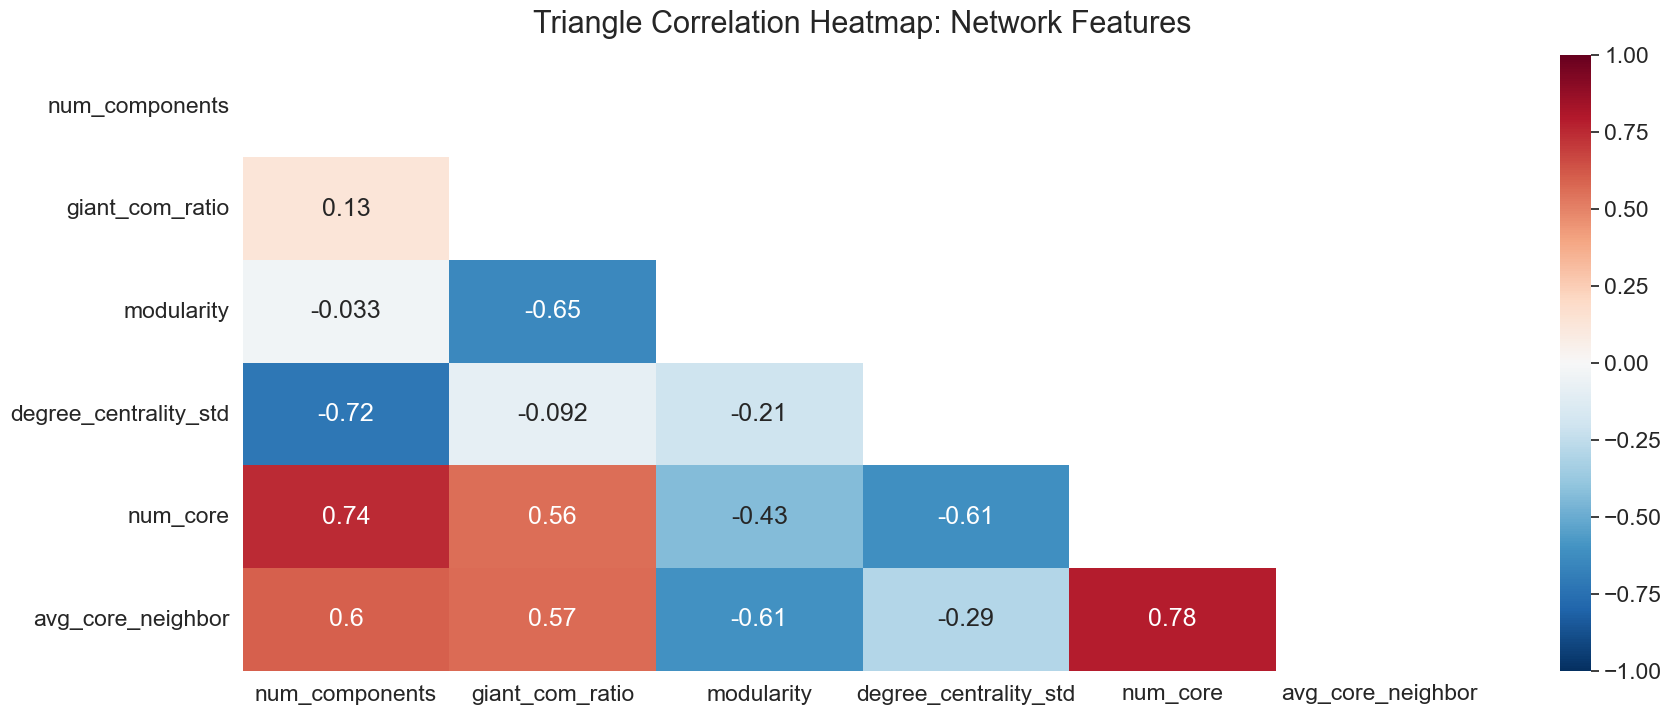

In [106]:
network_fea_cor = network_fea[['num_components', 'giant_com_ratio', 'modularity', 'degree_centrality_std', 'num_core', 'avg_core_neighbor']].corr()

plt.style.use('default')
plt.figure(figsize=(20, 8))

mask = np.triu(np.ones_like(network_fea_cor, dtype=np.bool))
sns.set(font_scale=1.5) 
heatmap = sns.heatmap(network_fea_cor, mask=mask, vmin=-1, vmax=1, annot=True, cmap='RdBu_r')
heatmap.set_title('Triangle Correlation Heatmap: Network Features', fontdict={'fontsize':22}, pad=16);

heatmap.set_facecolor((1,1,1))
plt.savefig(f"{FIG_SAVE_PATH}/fig4.png", dpi=100)